# BRAIN TUMOR SEGMENTATION

# Importing

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

In [3]:
path='../input/brain-tumor-classification-mri/Training/'
test_path='../input/brain-tumor-classification-mri/Testing/'
glioma=os.listdir(path+'glioma_tumor/')
meningioma=os.listdir(path+'meningioma_tumor/')
no_tumor=os.listdir(path+'no_tumor/')
pituitary=os.listdir(path+'pituitary_tumor/')

# Plotting different types of brain tumor images

**No tumor**

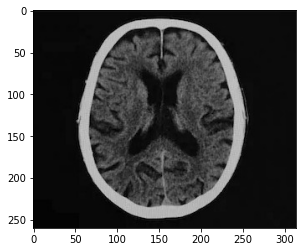

In [63]:
import cv2
plt.imshow(cv2.imread('../input/brain-tumor-classification-mri/Testing/no_tumor/image(103).jpg'))

**Glioma Tumor**

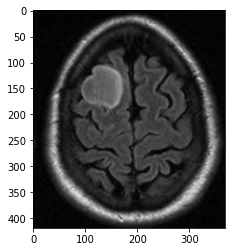

In [64]:
plt.imshow(cv2.imread('../input/brain-tumor-classification-mri/Testing/glioma_tumor/image(100).jpg'))

**Meningioma Tumor**

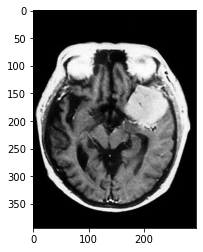

In [65]:
plt.imshow(cv2.imread('../input/brain-tumor-classification-mri/Testing/meningioma_tumor/image(107).jpg'))

**Pituitary Tumor**

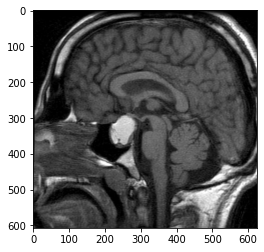

In [70]:
plt.imshow(cv2.imread('../input/brain-tumor-classification-mri/Testing/pituitary_tumor/image(43).jpg'))

# Feature extraction using VGG-16

In [4]:
vgg16 = tf.keras.applications.VGG16(include_top=False)
preprocess_input = tf.keras.applications.vgg16.preprocess_input
image = tf.keras.preprocessing.image

In [5]:
batch_size=32

In [6]:
def extract_features(img_paths, batch_size=batch_size):

    global vgg16
    n = len(img_paths)
    img_array = np.zeros((n, 299, 299, 3))
    
    for i, path in enumerate(img_paths):
        img = image.load_img(path, target_size=(299, 299))
        img = image.img_to_array(img)
        img = np.expand_dims(img, axis=0)
        x = preprocess_input(img)
        img_array[i] = x
    
    X = vgg16.predict(img_array, batch_size=batch_size, verbose=1)
    X = X.reshape(n, 512, -1)
    return X

In [7]:
X = extract_features(
    list(map(lambda x: path + 'glioma_tumor/' +x, glioma, )) + list(map(lambda x: path + 'meningioma_tumor/' + x, meningioma))+list(map(lambda x: path + 'no_tumor/' + x, no_tumor))+list(map(lambda x: path + 'pituitary_tumor/' + x, pituitary))
) 
y = np.array([3] * len(glioma) + [2] * len(meningioma)+ [1] * len(no_tumor)+ [0] * len(pituitary))

90/90 [==============================] - 25s 157ms/step


# Building Neural networks to connect the pretrained model

In [10]:
import keras
import keras.utils
from keras import utils as np_utils
from keras.models import Sequential
from keras.layers import Activation, Dropout, Dense, Flatten

def train_func():
    model=keras.Sequential()
    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dense(4, activation='softmax'))
    
    return model

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 41472)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              42468352  
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 4100      
Total params: 42,472,452
Trainable params: 42,472,452
Non-trainable params: 0
_________________________________________________________________


In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state=42)

# Early stopping

In [14]:
from keras.callbacks import EarlyStopping

earlystop = EarlyStopping(monitor = 'val_loss',min_delta = 0,patience = 3, verbose = 1,restore_best_weights = True)

# Training the model

In [15]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Dense
np.random.seed(42)

epochs = 10

model = train_func()
model.compile(keras.optimizers.Adam(learning_rate=0.005),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train, y_train,
                    validation_data=(X_test,y_test),
                    batch_size=batch_size,
                    epochs=epochs,callbacks=[earlystop])

Epoch 1/10
72/72 [==============================] - 2s 15ms/step - loss: 222.7759 - accuracy: 0.6442 - val_loss: 3.2326 - val_accuracy: 0.8928
Epoch 2/10
72/72 [==============================] - 1s 10ms/step - loss: 0.6829 - accuracy: 0.9476 - val_loss: 1.4493 - val_accuracy: 0.9136
Epoch 3/10
72/72 [==============================] - 1s 10ms/step - loss: 0.1819 - accuracy: 0.9782 - val_loss: 1.2732 - val_accuracy: 0.9220
Epoch 4/10
72/72 [==============================] - 1s 10ms/step - loss: 0.1706 - accuracy: 0.9824 - val_loss: 1.1821 - val_accuracy: 0.9192
Epoch 5/10
72/72 [==============================] - 1s 10ms/step - loss: 0.0771 - accuracy: 0.9883 - val_loss: 1.1483 - val_accuracy: 0.9206
Epoch 6/10
72/72 [==============================] - 1s 10ms/step - loss: 0.0682 - accuracy: 0.9878 - val_loss: 0.8644 - val_accuracy: 0.9318
Epoch 7/10
72/72 [==============================] - 1s 10ms/step - loss: 0.0255 - accuracy: 0.9964 - val_loss: 0.9697 - val_accuracy: 0.9276
Epoch 8/10


**Training as stopped at the ninth epoch due to early stopping(regularization)**

# Training and Loss graph

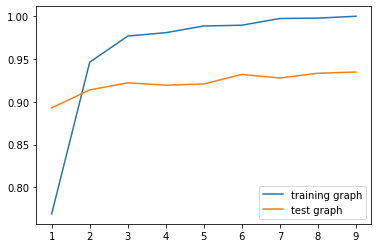

In [16]:
plt.plot(range(1,epochs+1-1), history.history['accuracy'], label='training graph')
plt.plot(range(1,epochs+1-1), history.history['val_accuracy'], label='test graph')
plt.legend()


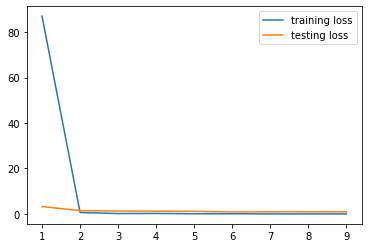

In [17]:
plt.plot(range(1,epochs+1-1), history.history['loss'], label='training loss')
plt.plot(range(1,epochs+1-1), history.history['val_loss'], label='testing loss')
plt.legend()

**It is evident from the above graphs that our model is not overfitting and it trades off bias and variance**

# Making Predictions

**Meningioma Tumor prediction**

In [49]:
X_test = extract_features(
    list(map(lambda x: '../input/brain-tumor-classification-mri/Testing/meningioma_tumor/image(109).jpg' , test_path))
)

2/2 [==============================] - 0s 174ms/step


In [50]:
y_pred = model.predict(X_test)

print(np.argmax(y_pred[0]))
if(np.argmax(y_pred[0])==2):
  print("You have meningioma tumor")
elif(np.argmax(y_pred[0])==0):
    print("You have pituitary tumor")
elif(np.argmax(y_pred[0])==1):
    print("You don't have no tumor") 
elif(np.argmax(y_pred[0])==3):
    print("You don't have glioma tumor")   
else:
    print("Invalid input")
    

2
You have meningioma tumor


**Pituitary tumor prediction**

In [61]:
X_test = extract_features(
    list(map(lambda x: '../input/brain-tumor-classification-mri/Testing/pituitary_tumor/image(28).jpg' , test_path))
)

y_pred = model.predict(X_test)

print(np.argmax(y_pred[0]))
if(np.argmax(y_pred[0])==2):
  print("You have meningioma tumor")
elif(np.argmax(y_pred[0])==0):
    print("You have pituitary tumor")
elif(np.argmax(y_pred[0])==1):
    print("You don't no tumor") 
elif(np.argmax(y_pred[0])==3):
    print("You don't have glioma tumor")   
    

2/2 [==============================] - 0s 174ms/step
0
You have pituitary tumor


**NO tumor prediction**

In [62]:
X_test = extract_features(
    list(map(lambda x: '../input/brain-tumor-classification-mri/Testing/no_tumor/image(30).jpg' , test_path))
)

y_pred = model.predict(X_test)

print(np.argmax(y_pred[0]))
if(np.argmax(y_pred[0])==2):
  print("You have meningioma tumor")
elif(np.argmax(y_pred[0])==0):
    print("You have pituitary tumor")
elif(np.argmax(y_pred[0])==1):
    print("You don't no tumor") 
elif(np.argmax(y_pred[0])==3):
    print("You don't have glioma tumor")  

2/2 [==============================] - 0s 175ms/step
1
You don't no tumor


# It's apparent that out Model classifies different types of Brain tumors with an accuracy of 92%